In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import lightgbm as lgb
import pickle
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### File and directory paths

In [2]:
# DATA_FILE='/home/shiv/Documents/DataScience/DrCADx/Two-Step-Feature-Enhancement/final_feat.csv'

DATA_FILE='/home/shiv/Documents/DataScience/DrCADx/Two-Step-Feature-Enhancement/ResNet50_output/CRIC_data.csv'
PATHS_DICT_FILE = '/home/shiv/Documents/DataScience/DrCADx/Two-Step-Feature-Enhancement/data_paths.cpickle'
RESULTS_DIR='/home/shiv/Documents/DataScience/DrCADx/Two-Step-Feature-Enhancement/Results/'

In [3]:
with open(PATHS_DICT_FILE, "rb") as f:
    paths_dict = pickle.load(f)

paths = paths_dict['CRIC_data'] # for now, only deals with CRIC dataset
paths = np.expand_dims(paths,1)

data_set=np.loadtxt(open(DATA_FILE,"rb"),delimiter=",",skiprows=0)

numRowsData=np.shape(data_set)[0]    # number of instances in the  dataset
numFeaturesData=np.shape(data_set)[1]-1 #number of features in the  dataset

dataInput=data_set[0:numRowsData,1:] # 1: for class in first column, 0:-1 for class in last column
dataTarget=data_set[0:numRowsData,0]  # -1 for class in last column, 0 for class in first column

dataInput=np.hstack([dataInput, paths])
trainInput, testInput, trainOutput, testOutput = train_test_split(dataInput, dataTarget, 
                                                    test_size=0.3, random_state=1)#, stratify=dataTarget)

In [4]:
trainPaths = trainInput[:,-1] # save the paths to the training image files
testPaths = testInput[:,-1]   # save the paths to the test image files (used later for analysis)
trainInput = trainInput[:,0:-1]
testInput = testInput[:,0:-1]

### Train a LightGBM model on all 100k+ features

If you already have a trained model, jump to [here](#load_trained_model)

In [ ]:
eval_result = {}
lgb_train=lgb.Dataset(trainInput, trainOutput)
lgb_test=lgb.Dataset(testInput, testOutput)
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['num_class']=6
params['num_iterations']=500

lgb_model = lgb.train(params,
                      lgb_train,
                      early_stopping_rounds=20,
                      evals_result= eval_result,
                      valid_sets=lgb_test,
                      )

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

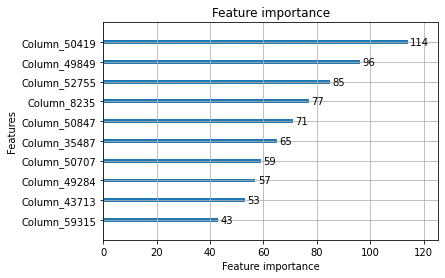

In [10]:
lgb.plot_importance(lgb_model, max_num_features=10)

### Save the trained model with all features

In [8]:
save_file = os.path.join(RESULTS_DIR, r'lgb_allfeatures.model')
lgb_model.save_model(save_file)

<a id='load_trained_model'></a>
### Load the trained model with all features

In [5]:
save_file = os.path.join(RESULTS_DIR, r'lgb_allfeatures.model')
lgb_model = lgb.Booster(model_file=save_file)

### Now train a LightGBM model with 1000 most important features

In [6]:
arr = lgb_model.feature_importance()
idx = np.argsort(-arr)[:1000]

In [7]:
lgb_train=lgb.Dataset(trainInput[:, idx], trainOutput)
lgb_test=lgb.Dataset(testInput[:,idx], testOutput)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['num_class']=6
params['num_iterations']=500

lgb_fs = lgb.train(params,
                      lgb_train,
                      early_stopping_rounds=20,
                      valid_sets=lgb_test,
                      )

/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112388
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 1000
[LightGBM] [Info] Start training from score -1.856899
[LightGBM] [Info] Start training from score -2.281782
[LightGBM] [Info] Start training from score -2.023953
[LightGBM] [Info] Start training from score -1.730605
[LightGBM] [Info] Start training from score -1.183170
[LightGBM] [Info] Start training from score -2.070473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's multi_logloss: 1.14163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's multi_logloss: 1.125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's multi_logloss: 0.908098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	valid_0's multi_logloss: 0.899258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's multi_logloss: 0.763584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's multi_logloss: 0.759063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's multi_logloss: 0.755082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's multi_logloss: 0.687659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's multi_logloss: 0.685797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's multi_logloss: 0.683937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[123]	valid_0's multi_logloss: 0.653523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's multi_logloss: 0.652044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's multi_logloss: 0.651821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's multi_logloss: 0.651178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's multi_logloss: 0.651381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's multi_logloss: 0.650872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's multi_logloss: 0.650478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's multi_logloss: 0.649734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's multi_logloss: 0.650362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

#### Record the metrics for LightGBM

In [8]:
def record_scores(res_dict, acc_score, prec_score, rec_score, f_score, train):
    if train:
        s = 'train'
    else:
        s = 'test'
    res_dict[s + 'Acc'] = acc_score
    res_dict[s + 'Prec Macro'] = prec_score
    res_dict[s + 'Rec Macro'] = rec_score
    res_dict[s + 'F1 Macro'] = f_score       

results_lgb_dict = {}

train_preds = lgb_fs.predict(trainInput[:,idx])
train_preds = np.argmax(train_preds, axis=1)

acc_score = accuracy_score(trainOutput, train_preds)
prec_score = precision_score(trainOutput, train_preds, average='macro')
rec_score = recall_score(trainOutput, train_preds, average='macro')
f_score = f1_score(trainOutput, train_preds, average='macro')

record_scores(results_lgb_dict, acc_score, prec_score, rec_score, f_score, True)

print("Train", acc_score, prec_score, rec_score, f_score)

test_preds = lgb_fs.predict(testInput[:,idx])
test_preds = np.argmax(test_preds, axis=1)

acc_score = accuracy_score(testOutput, test_preds)
prec_score = precision_score(testOutput, test_preds, average='macro')
rec_score = recall_score(testOutput, test_preds, average='macro')
f_score = f1_score(testOutput, test_preds, average='macro')

record_scores(results_lgb_dict, acc_score, prec_score, rec_score, f_score, False)
acc_score, prec_score, rec_score, f_score

Train 1.0 1.0 1.0 1.0


(0.7867132867132867,
 0.7814610439779086,
 0.7417778870426882,
 0.7458451137707823)

#### Record the metrics for SVM

In [9]:
svc=svm.SVC(kernel='rbf').fit(trainInput[:,idx],trainOutput)

train_preds = svc.predict(trainInput[:,idx])
acc_score = accuracy_score(trainOutput, train_preds)
prec_score = precision_score(trainOutput, train_preds, average='macro')
rec_score = recall_score(trainOutput, train_preds, average='macro')
f_score = f1_score(trainOutput, train_preds, average='macro')

results_svm_dict = {}
record_scores(results_svm_dict, acc_score, prec_score, rec_score, f_score, True)

print("Train", acc_score, prec_score, rec_score, f_score)

test_preds = svc.predict(testInput[:,idx])

acc_score = accuracy_score(testOutput, test_preds)
prec_score = precision_score(testOutput, test_preds, average='macro')
rec_score = recall_score(testOutput, test_preds, average='macro')
f_score = f1_score(testOutput, test_preds, average='macro')

record_scores(results_svm_dict, acc_score, prec_score, rec_score, f_score, False)
acc_score, prec_score, rec_score, f_score

Train 0.9774774774774775 0.9813302194881143 0.9682245512878614 0.9739104545101359


(0.8146853146853147, 0.8156622325723628, 0.7765092006824199, 0.779452194456439)

### Plot Results for LGBM and SVM

In [10]:
df_lgb = pd.DataFrame(results_lgb_dict, index=[0])
df_lgb = df_lgb.T
df_lgb.columns = ['value']

In [11]:
df_svm = pd.DataFrame(results_svm_dict, index=[0])
df_svm = df_svm.T
df_svm.columns = ['value']

In [13]:
def get_type(row):
    str_idx = str(row.name)
    # print(str_idx)    
    if 'Acc' in str_idx:
        row['met_type']='accuracy'
    elif 'Prec Micro' in str_idx:
        row['met_type']='precision micro'
    elif 'Prec Macro' in str_idx:
        row['met_type']='precision macro'
    elif 'Rec Micro' in str_idx:
        row['met_type']='recall micro'
    elif 'Rec Macro' in str_idx:
        row['met_type']='recall macro'
    elif 'F1 Micro' in str_idx:
        row['met_type']='F1 micro'
    elif 'F1 Macro' in str_idx:
        row['met_type']='F1 macro'
    else:
        print(str_idx)
        assert(0)
    if str_idx.startswith('train'):
        row['split_type']='train'
    elif str_idx.startswith('test'):
        row['split_type']='test'
    else:
        assert(0)
    return row
        
df_resnet_lgb = df_lgb.apply(get_type, axis=1)
df_resnet_svm = df_svm.apply(get_type, axis=1)

# df_both = df_both.apply(get_type, axis=1)
# df_all = df_all.apply(get_type, axis=1)

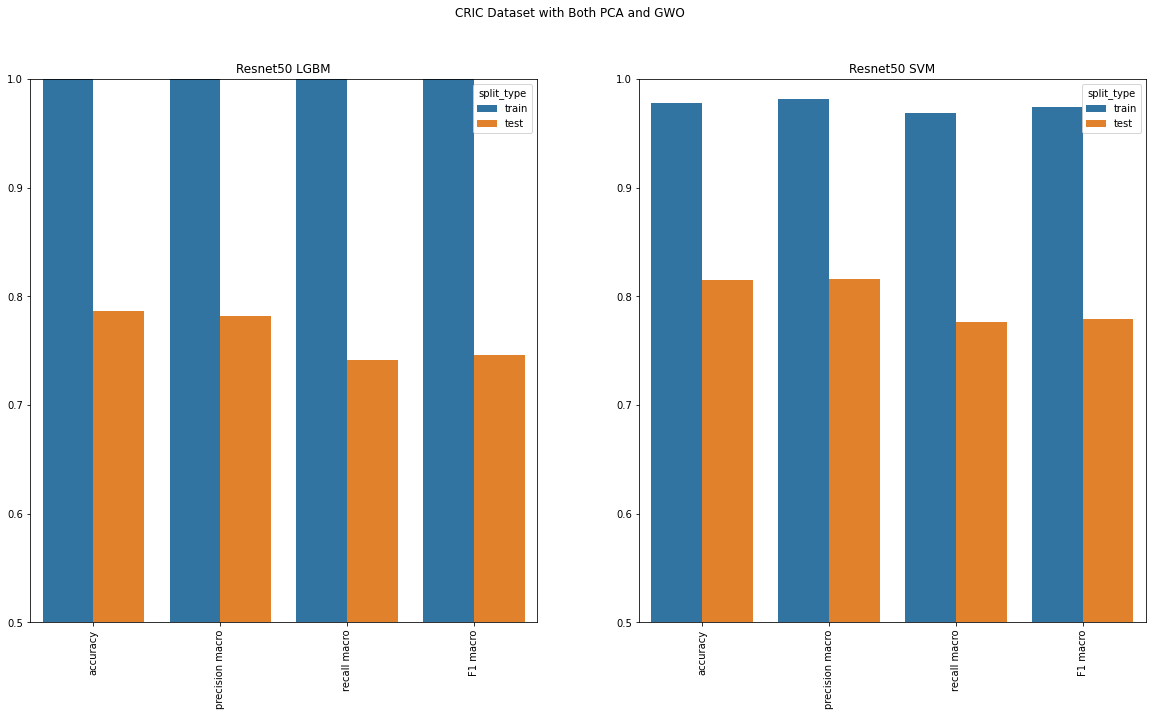

In [14]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('CRIC Dataset with Both PCA and GWO')
plt.subplot(1,2,1)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_resnet_lgb)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Resnet50 LGBM')
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_resnet_svm)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Resnet50 SVM')
plt.xticks(rotation=90);

#### Confusion matrix for SVM

In [15]:
confusion_matrix(testOutput, test_preds) # true labels are rows, predicted are columns

array([[35,  1,  4,  4,  2,  0],
       [ 0, 11,  0, 18,  4,  0],
       [ 3,  1, 26,  2,  0,  0],
       [ 1,  2,  0, 41,  3,  0],
       [ 5,  0,  0,  1, 85,  0],
       [ 1,  0,  0,  1,  0, 35]])

In [21]:
with open(RESULTS_DIR + '../le.cpickle', 'rb') as f:
    le = pickle.load(f)
le.classes_ # most incorrect predictions are for ASC-US

array(['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NILM', 'SCC'], dtype='<U6')

In [16]:
np.where((testOutput==1) & (test_preds==3)) # predict: LSIL true:  ASC-US

(array([  6,  27,  61,  66,  73,  89, 108, 120, 170, 173, 180, 186, 192,
        221, 239, 257, 276, 284]),)

### Look at an erroneous prediction

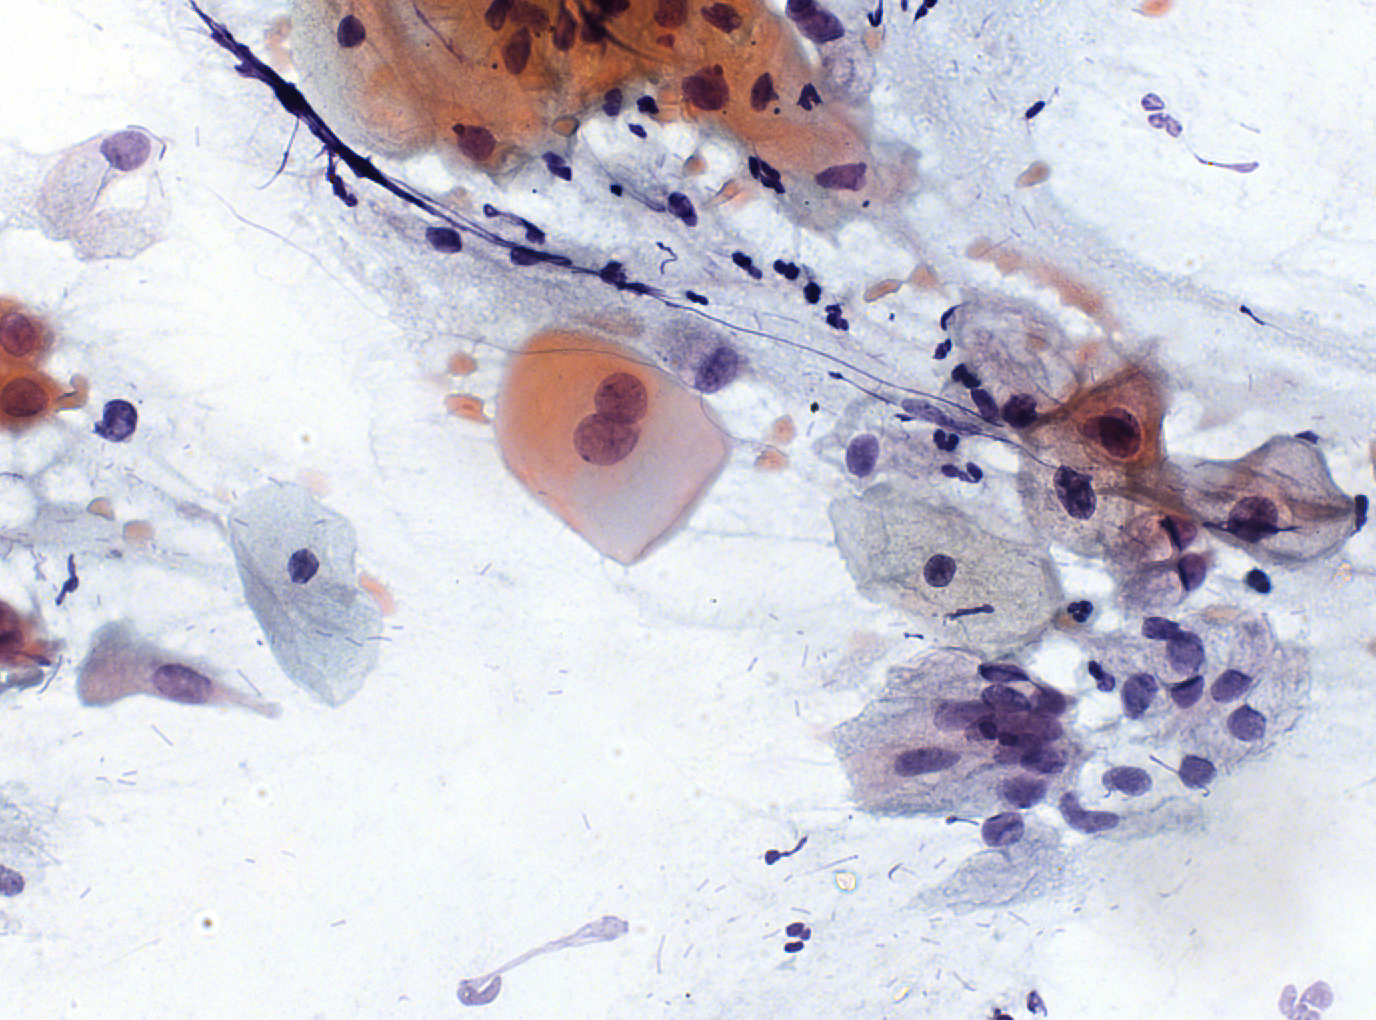

In [24]:
from IPython.display import Image 
pil_img = Image(filename=testPaths[276])
display(pil_img)

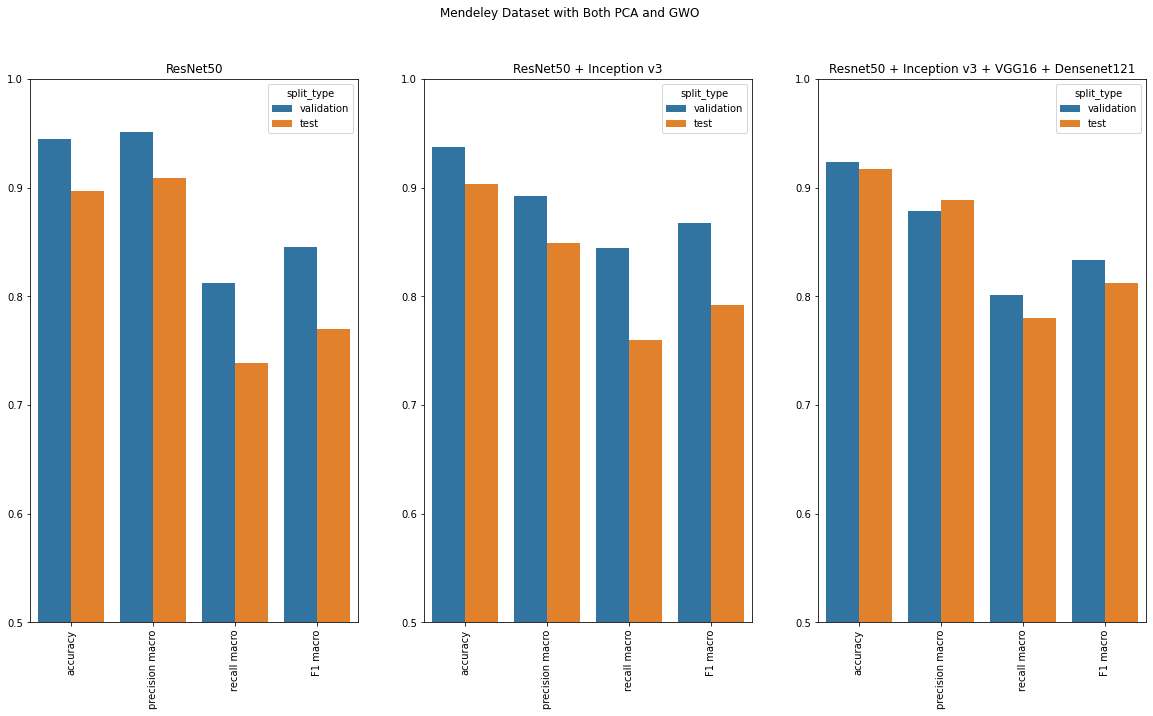

In [7]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Mendeley Dataset with Both PCA and GWO')
plt.subplot(1,3,1)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_resnet)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('ResNet50')
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_both)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('ResNet50 + Inception v3')
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_all)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Resnet50 + Inception v3 + VGG16 + Densenet121')
plt.xticks(rotation=90);

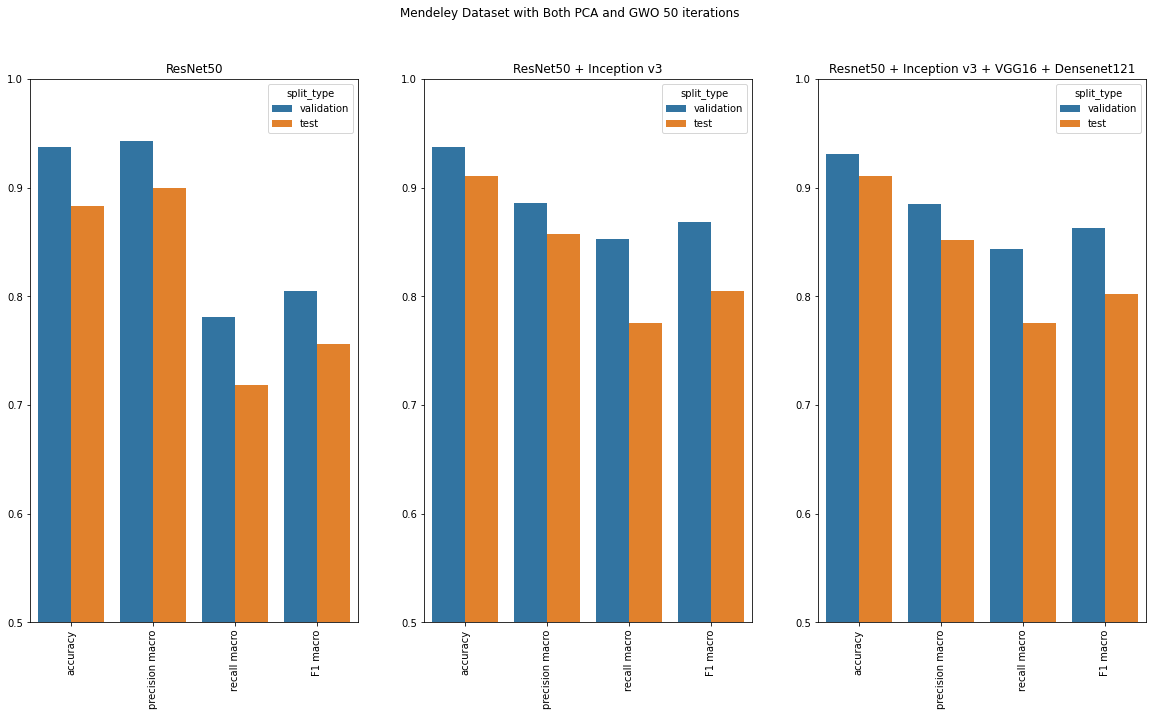

In [8]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Mendeley Dataset with Both PCA and GWO 50 iterations')
plt.subplot(1,3,1)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_resnet_50)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('ResNet50')
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_both_50)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('ResNet50 + Inception v3')
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.barplot(x='met_type',
            y='value', hue='split_type', data=df_all_50)
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Resnet50 + Inception v3 + VGG16 + Densenet121')
plt.xticks(rotation=90);